# Árboles de decisión

## Preparación de ambiente

### Carga de módulos

In [2]:
import pydotplus
import numpy as np
import pandas as pd
from sklearn.tree import _tree
from IPython.display import Image 
from sklearn.pipeline import Pipeline
from six import StringIO 
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split

### Funciones relevantes

In [3]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    features = ','.join(feature_names)
    print(f"def tree({features}):")

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(f"{indent}if {name} <= {threshold}:")
            recurse(tree_.children_left[node], depth + 1)
            print(f"{indent}else:  # if {name} > {threshold}")
            recurse(tree_.children_right[node], depth + 1)
        else:
            print(f"{indent}return {tree_.value[node]}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [4]:
def classification_metrics(X, y, estimator):
    ls_scores_roc = cross_val_score(estimator=estimator, X=X, y=y, scoring="roc_auc", n_jobs=-1, cv=4)
    print(f"ROC media: {np.mean(ls_scores_roc):,.2f}, desviación estándar: {np.std(ls_scores_roc)}")

## Carga de datos

### Lectura de datos

In [5]:
df = pd.read_csv("tictactoe.csv")

In [6]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive
...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,negative
954,o,x,o,x,x,o,x,o,x,negative
955,o,x,o,x,o,x,x,o,x,negative
956,o,x,o,o,x,x,x,o,x,negative


### EDA

In [7]:
df.sample(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
52,x,x,x,b,x,o,b,o,o,positive
249,x,b,o,x,o,o,x,x,b,positive
299,o,x,x,o,x,o,x,x,o,positive
691,x,o,o,x,o,x,o,x,b,negative
221,x,o,b,b,x,b,b,o,x,positive


In [8]:
df.shape

(958, 10)

### Separación de sets

In [9]:
X = df[[f"V{x}" for x in range(1, 10)]]
y = df["V10"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

## Modelado

### Generación de pipeline

In [11]:
ohe = OneHotEncoder(sparse=False)

In [12]:
ohe.fit_transform(df[[f"V{x}" for x in range(1, 10)]])

array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [13]:
ohe.get_feature_names?

Signature: ohe.get_feature_names(input_features=None)
Docstring:
Return feature names for output features.

Parameters
----------
input_features : list of str of shape (n_features,)
    String names for input features if available. By default,
    "x0", "x1", ... "xn_features" is used.

Returns
-------
output_feature_names : ndarray of shape (n_output_features,)
    Array of feature names.
File:      ~/VirtualEnvs/Python 3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py
Type:      method


In [14]:
ohe.get_feature_names(X.columns)

array(['V1_b', 'V1_o', 'V1_x', 'V2_b', 'V2_o', 'V2_x', 'V3_b', 'V3_o',
       'V3_x', 'V4_b', 'V4_o', 'V4_x', 'V5_b', 'V5_o', 'V5_x', 'V6_b',
       'V6_o', 'V6_x', 'V7_b', 'V7_o', 'V7_x', 'V8_b', 'V8_o', 'V8_x',
       'V9_b', 'V9_o', 'V9_x'], dtype=object)

In [15]:
DecisionTreeClassifier?

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight=None,
    ccp_alpha=0.0,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "entropy" for the information gain.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None
    The maximum depth of the tree. If None, then nodes are expanded until
    al

In [16]:
tree = DecisionTreeClassifier(max_depth=3)

In [17]:
pipe = Pipeline([("encoder", ohe), ("tree", tree)])

### Entrenamiento

In [18]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('encoder', OneHotEncoder(sparse=False)),
                ('tree', DecisionTreeClassifier(max_depth=3))])

In [19]:
pipe.score(X_train, y_train)

0.7716417910447761

In [21]:
y_train.value_counts(True)

positive    0.674627
negative    0.325373
Name: V10, dtype: float64

In [22]:
pipe.score(X_test, y_test)

0.6944444444444444

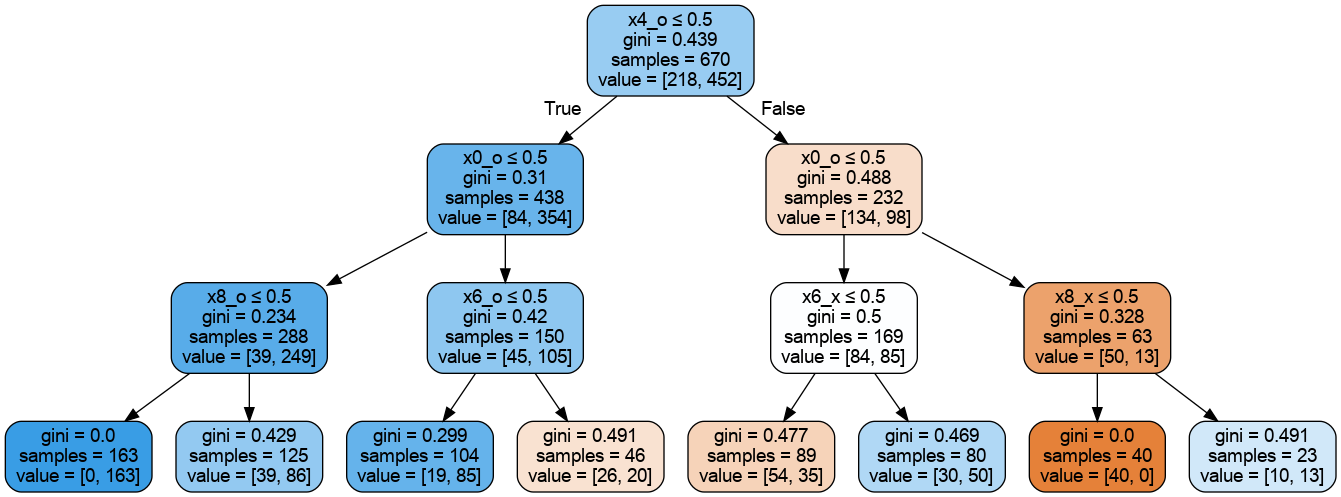

In [23]:
dot_data = StringIO()
export_graphviz(pipe["tree"], out_file=dot_data, feature_names=ohe.get_feature_names(),
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [24]:
tree.classes_

array(['negative', 'positive'], dtype=object)

In [25]:
print(tree_to_code(feature_names=ohe.get_feature_names(), tree=tree))

def tree(x0_b,x0_o,x0_x,x1_b,x1_o,x1_x,x2_b,x2_o,x2_x,x3_b,x3_o,x3_x,x4_b,x4_o,x4_x,x5_b,x5_o,x5_x,x6_b,x6_o,x6_x,x7_b,x7_o,x7_x,x8_b,x8_o,x8_x):
  if x4_o <= 0.5:
    if x0_o <= 0.5:
      if x8_o <= 0.5:
        return [[  0. 163.]]
      else:  # if x8_o > 0.5
        return [[39. 86.]]
    else:  # if x0_o > 0.5
      if x6_o <= 0.5:
        return [[19. 85.]]
      else:  # if x6_o > 0.5
        return [[26. 20.]]
  else:  # if x4_o > 0.5
    if x0_o <= 0.5:
      if x6_x <= 0.5:
        return [[54. 35.]]
      else:  # if x6_x > 0.5
        return [[30. 50.]]
    else:  # if x0_o > 0.5
      if x8_x <= 0.5:
        return [[40.  0.]]
      else:  # if x8_x > 0.5
        return [[10. 13.]]
None


### Cross validation

In [26]:
classification_metrics(X=X_train, y=y_train, estimator=pipe)

ROC media: 0.80, desviación estándar: 0.028438721201831677


In [27]:
pipe.score(X_test, y_test)

0.6944444444444444

### Hyperparametrización

In [28]:
tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [29]:
param_dist = {"tree__max_depth": range(1, 5),
              "tree__max_features": ["auto", "sqrt", "log2"],
              "tree__min_samples_leaf": [x/100 for x in range(5, 51, 1)] + [x for x in range(1, 21)], 
              "tree__criterion": ["gini", "entropy"],
              "tree__splitter": ["best", "random"],
              "tree__class_weight": ["balanced", None]}

In [30]:
search = GridSearchCV(param_grid=param_dist, cv=4, n_jobs=-1, scoring="roc_auc", estimator=pipe, verbose=5,)

In [31]:
search.fit(X_train, y_train)

Fitting 4 folds for each of 6336 candidates, totalling 25344 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('encoder', OneHotEncoder(sparse=False)),
                                       ('tree',
                                        DecisionTreeClassifier(max_depth=3))]),
             n_jobs=-1,
             param_grid={'tree__class_weight': ['balanced', None],
                         'tree__criterion': ['gini', 'entropy'],
                         'tree__max_depth': range(1, 5),
                         'tree__max_features': ['auto', 'sqrt', 'log2'],
                         'tree__min_samples_leaf': [0.05, 0.06, 0.07, 0.08,
                                                    0.09, 0.1, 0.11, 0.12, 0.13,
                                                    0.14, 0.15, 0.16, 0.17,
                                                    0.18, 0.19, 0.2, 0.21, 0.22,
                                                    0.23, 0.24, 0.25, 0.26,
                                                    0.27, 0.28, 0.29, 0.3, 0.31,
               

In [32]:
search.best_estimator_

Pipeline(steps=[('encoder', OneHotEncoder(sparse=False)),
                ('tree',
                 DecisionTreeClassifier(max_depth=4, max_features='auto',
                                        min_samples_leaf=6))])

In [33]:
search.score(X_test, y_test)

0.7563772938092358

In [34]:
search.best_score_

0.8209145287685111

### Preservación de modelo

In [35]:
pd.to_pickle(pipe, "/home/oscar/Documentos/Oscar/Diplomado/Generación 3/Módulo 2/tic_tac_toe/home/dt_tictactoe.pickle")

In [36]:
X["proba"] = pipe.predict_proba(X)[:, 0]

In [37]:
pd.DataFrame(zip(ohe.get_feature_names(X_train.columns), tree.feature_importances_)).sort_values(by=1)

,0,1
0,V1_b,0.000000
22,V8_o,0.000000
18,V7_b,0.000000
17,V6_x,0.000000
16,V6_o,0.000000
15,V6_b,0.000000
14,V5_x,0.000000
23,V8_x,0.000000
12,V5_b,0.000000
11,V4_x,0.000000


In [38]:
X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,proba
0,x,x,x,x,o,o,x,o,o,0.375000
1,x,x,x,x,o,o,o,x,o,0.606742
2,x,x,x,x,o,o,o,o,x,0.606742
3,x,x,x,x,o,o,o,b,b,0.606742
4,x,x,x,x,o,o,b,o,b,0.606742
...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,0.434783
954,o,x,o,x,x,o,x,o,x,0.182692
955,o,x,o,x,o,x,x,o,x,0.434783
956,o,x,o,o,x,x,x,o,x,0.182692


In [39]:
ohe

OneHotEncoder(sparse=False)

In [40]:
ohe?

Type:        OneHotEncoder
String form: OneHotEncoder(sparse=False)
File:        ~/VirtualEnvs/Python 3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py
Docstring:  
Encode categorical features as a one-hot numeric array.

The input to this transformer should be an array-like of integers or
strings, denoting the values taken on by categorical (discrete) features.
The features are encoded using a one-hot (aka 'one-of-K' or 'dummy')
encoding scheme. This creates a binary column for each category and
returns a sparse matrix or dense array (depending on the ``sparse``
parameter)

By default, the encoder derives the categories based on the unique values
in each feature. Alternatively, you can also specify the `categories`
manually.

This encoding is needed for feeding categorical data to many scikit-learn
estimators, notably linear models and SVMs with the standard kernels.

Note: a one-hot encoding of y labels should use a LabelBinarizer
instead.

Read more in the :ref:`User 

In [41]:
X.to_csv("/home/oscar/Documentos/Oscar/Diplomado/Generación 3/Módulo 2/tic_tac_toe/home/tree_data.csv")